# All-Zone Analysis of UCB-Based Policy Selection

1. Compare the number of evaluations vs Spearman Rank Correlation to validation data
2. UCB evaluates each policy for 1-day and takes aggregate energy consumption as reward
3. Tested on the 15-zone test building

In [33]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
import json
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

%matplotlib widget

## Valdiation Data

In [24]:
eval_data_loc = "../data/1month_eval.csv"
invalid_policies_loc = "../data/invalid_policy_list.json"

eval_df = pd.read_csv(eval_data_loc, header=None, names=["datetime", "policy", "zone", "energy"])
with open(invalid_policies_loc) as f:
    invalid_policies = json.load(f)["invalid_policies"]

## UCB Zone Data

In [25]:
all_zones = list(eval_df["zone"].unique())

ucb_dfs = {}
for zone in all_zones:
    df_loc = f"../data/ucb_log_data/{zone}/8/ucb_log_data.csv"
    ucb_dfs[zone] = pd.read_csv(df_loc)
# core_top_loc = "../data/ucb_log_data/Perimeter_bot_ZN_1/8/ucb_log_data.csv"
# core_top_df = pd.read_csv(core_top_loc)
# ucb_dfs

In [26]:
ucb_eval_cols = ucb_dfs[all_zones[0]].columns
policy_names = [col[15:-10] for col in ucb_eval_cols if "score" in col]
num_policies = len(policy_names)

## UCB Q-Value Plot

In [27]:
q_val_dfs = {}
for zone in all_zones:
    q_vals_df = pd.DataFrame()
    q_vals_df["timestep"] = ucb_dfs[zone][len(policy_names):].index

    for policy in policy_names:
        score_col_name = f"policy_library/{policy}.pth_score"
        count_col_name = f"policy_library/{policy}.pth_count"
        all_columns = list(ucb_dfs[zone].columns)
        q_vals_df[f"{policy}_value"] = ucb_dfs[zone].iloc[len(policy_names):, all_columns.index(score_col_name)].values
        q_vals_df[f"{policy}_count"] = ucb_dfs[zone].iloc[len(policy_names):, all_columns.index(count_col_name)].values
        q_vals_df = q_vals_df.copy()
    q_val_dfs[zone] = q_vals_df

Text(0.5, 0, 'Timestep (days)')

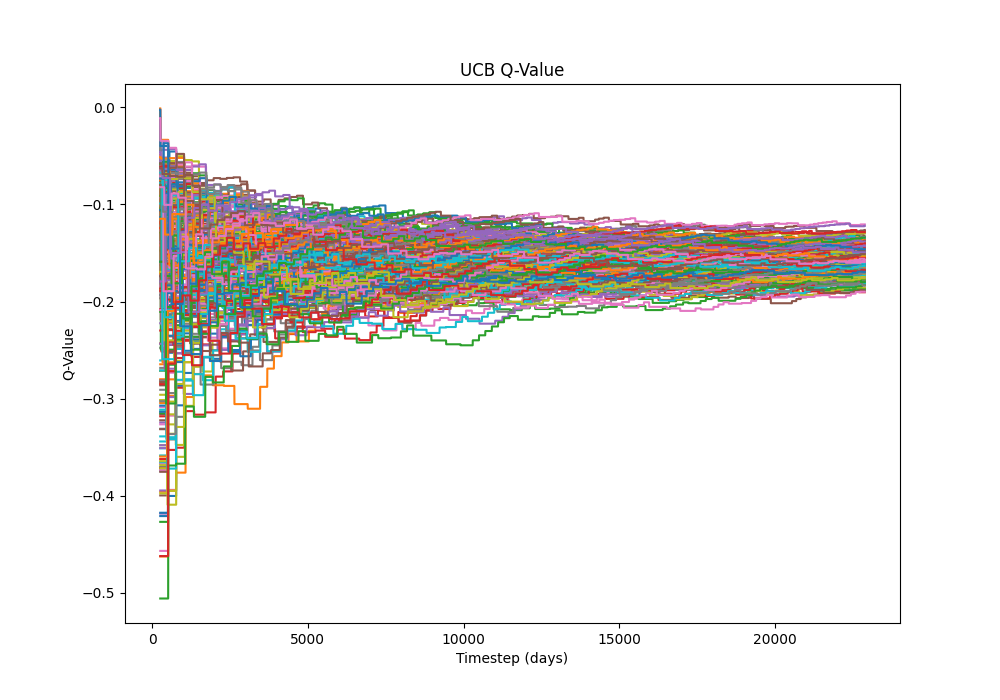

In [7]:
plt.figure(figsize=(10, 7))
plt.title("UCB Q-Value")
for policy in policies_for_plot:
    sns.lineplot(x="timestep", y=f"{policy}_value", data=core_top_q_vals_df)
plt.ylabel("Q-Value")
plt.xlabel("Timestep (days)")

Text(0.5, 0, 'Timestep (days)')

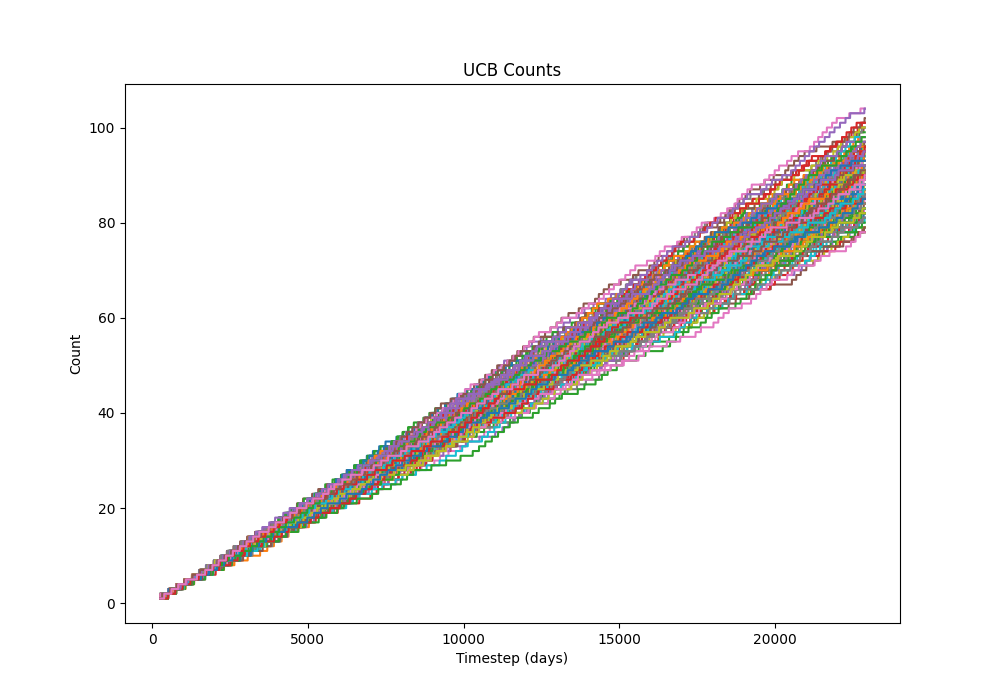

In [8]:
plt.figure(figsize=(10, 7))
plt.title("UCB Counts")
for policy in policies_for_plot:
    sns.lineplot(x="timestep", y=f"{policy}_count", data=core_top_q_vals_df)
plt.ylabel("Count")
plt.xlabel("Timestep (days)")

In [28]:
timestep = q_val_dfs[all_zones[0]]["timestep"].values[-1]
zone_eval_dfs = {}

for zone in all_zones:
    # zone_eval_df = eval_df[eval_df["zone"] == zone]
    zone_eval_df = pd.DataFrame(columns=["datetime", "policy", "zone", "energy"])
    for name in policy_names:
        name = f"policy_library/{name}.pth"
        zone_eval_df = pd.concat([zone_eval_df, eval_df[eval_df["policy"] == name]])
        # print(zone_eval_df)
    zone_eval_df = zone_eval_df[zone_eval_df["zone"] == zone]
    zone_eval_df = zone_eval_df.sort_values(by=["energy"])
    zone_eval_dfs[zone] = zone_eval_df

In [29]:
for zone in all_zones:
    print(zone)
    ucb_row_idx = q_val_dfs[zone]["timestep"].values[-1]
    row = q_val_dfs[zone][q_val_dfs[zone]["timestep"] == ucb_row_idx]
    ucb_scores =[]
    for policy_name in zone_eval_dfs[zone]["policy"].values:
        col_name = policy_name[15:-4] + "_value"
        value = row[col_name].values[0]
        ucb_scores.append(value)
    zone_eval_dfs[zone]["ucb_scores"] = ucb_scores

Core_top
Core_mid
Perimeter_bot_ZN_4
Perimeter_mid_ZN_3
Perimeter_mid_ZN_2
Perimeter_mid_ZN_1
Perimeter_mid_ZN_4
Core_bottom
Perimeter_top_ZN_3
Perimeter_top_ZN_2
Perimeter_top_ZN_1
Perimeter_top_ZN_4
Perimeter_bot_ZN_3
Perimeter_bot_ZN_2
Perimeter_bot_ZN_1


In [31]:
ucb_corr = {}
for zone in all_zones:
    ucb_corr[zone] = spearmanr(zone_eval_dfs[zone]["energy"].values, zone_eval_dfs[zone]["ucb_scores"].values)
ucb_corr

{'Core_top': SpearmanrResult(correlation=-0.19703462921907516, pvalue=0.0015010290005472832),
 'Core_mid': SpearmanrResult(correlation=-0.5288859605465568, pvalue=6.339121805997292e-20),
 'Perimeter_bot_ZN_4': SpearmanrResult(correlation=-0.6079745328477061, pvalue=2.2892190602075086e-27),
 'Perimeter_mid_ZN_3': SpearmanrResult(correlation=-0.2955353305130757, pvalue=1.415172547703067e-06),
 'Perimeter_mid_ZN_2': SpearmanrResult(correlation=-0.5543828047235543, pvalue=4.1399556564935536e-22),
 'Perimeter_mid_ZN_1': SpearmanrResult(correlation=-0.3100221416613881, pvalue=3.950956406668295e-07),
 'Perimeter_mid_ZN_4': SpearmanrResult(correlation=-0.5156207583024159, pvalue=7.37588886420176e-19),
 'Core_bottom': SpearmanrResult(correlation=-0.6970127137815582, pvalue=1.0463918121800788e-38),
 'Perimeter_top_ZN_3': SpearmanrResult(correlation=-0.3762667883908585, pvalue=4.2268920597798157e-10),
 'Perimeter_top_ZN_2': SpearmanrResult(correlation=-0.4551560661931046, pvalue=1.511839162892136

In [34]:
with open("ucb_corr_12_07_2022.pkl", "wb+") as f:
    pickle.dump(ucb_corr, f)